In [1]:
import numpy as np
import wandb

from scorta.recsys.candidate_generate import CandidateMerger
from atma_16.dataset.dataset import AtmaData16Loader
from pathlib import Path
import polars as pl

from hydra import initialize, compose
from scorta.utils.utils import seed_everything

from scorta.feature.feature import FeatureMerger
import pandas as pd
import seaborn as sns

In [2]:
seed_everything()

exp_name = "005_new_enviroment"
input_dir = Path("../input")
candidate_dir = input_dir / "candidate"
candidate_dir.mkdir(exist_ok=True)

feature_dir = input_dir / "feature"
feature_dir.mkdir(exist_ok=True)

output_dir = Path("../output") / exp_name
output_dir.mkdir(parents=True, exist_ok=True)


with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")
    print(cfg.feature)

wandb.init(project="atma16", config=dict(cfg))

dl = AtmaData16Loader(input_dir)
train_log = dl.load_train_log()

yado = dl.load_yado()
target_df = dl.load_train_label().with_columns(pl.lit(1).alias("target"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'YadoRaw': {'feature_cols': ['yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'], 'key_cols': ['yad_no']}, 'Session': {'feature_cols': ['user_mode_wid_cd', 'user_mode_ken_cd', 'user_mode_lrg_cd', 'user_mode_sml_cd', 'user_mean_total_room_cnt', 'user_mean_wireless_lan_flg', 'user_mean_onsen_flg', 'user_mean_kd_stn_5min', 'user_mean_kd_bch_5min', 'user_mean_kd_slp_5min', 'user_mean_kd_conv_walk_5min'], 'key_cols': ['session_id']}, 'YadoRank': {'feature_cols': ['yad_cnt', 'yad_cnt_rank', 'yad_cnt_rank_wid_cd', 'yad_cnt_rank_ken_cd', 'yad_cnt_rank_lrg_cd', 'yad_cnt_rank_sml_cd'], 'key_cols': ['yad_no']}}


wandb: Currently logged in as: zerebom. Use `wandb login --relogin` to force relogin


In [3]:
train_log = dl.load_train_log()
label = dl.load_train_label()
test_log = dl.load_train_log()

In [41]:
from atma_16.candidate.candidate import (
    LastSeenedCandidate,
    PopularAtCDCandidate,
    # TopBookedFromLastViewCandidate,
    CoVisitCandidate,
)

train_candidates = [
    CoVisitCandidate(dl, candidate_dir, target_df=target_df),
    # TopBookedFromLastViewCandidate(dl, candidate_dir, target_df=target_df),
    LastSeenedCandidate(dl, candidate_dir, target_df=target_df),
    PopularAtCDCandidate(dl, candidate_dir, target_df=target_df),
]
test_candidates = [
    CoVisitCandidate(dl, candidate_dir, mode="test"),
    # TopBookedFromLastViewCandidate(dl, candidate_dir, mode="test"),
    LastSeenedCandidate(dl, candidate_dir, mode="test"),
    PopularAtCDCandidate(dl, candidate_dir, mode="test"),
]

cands_dic = {"train": train_candidates, "test": test_candidates}

all_eval_df = pd.DataFrame()
for mode, candidates in cands_dic.items():
    print(mode)
    for cand in candidates:
        df = cand.generate()
        cand.save(df)
        if mode == "train":
            eval_df = cand.evaluator.evaluate(df, cand.class_name)
            all_eval_df = pd.concat([all_eval_df, eval_df])

    cm = CandidateMerger(
        dl, candidates, output_dir=candidate_dir, mode=mode, target_df=target_df if mode == "train" else None
    )
    merged_df = cm.merge()
    cm.save(merged_df)
    if mode == "train":
        eval_df = cm.evaluator.evaluate(merged_df, cm.class_name)
        all_eval_df = pd.concat([all_eval_df, eval_df])


wandb.log({"candidate_table": wandb.Table(dataframe=all_eval_df)})

train


3it [00:04,  1.49s/it]


test


3it [00:02,  1.11it/s]


(array([1.66401e+05, 8.29460e+04, 2.61750e+04, 8.94200e+03, 2.69300e+03,
        1.15100e+03, 3.37000e+02, 3.80000e+01, 1.00000e+01, 5.00000e+00]),
 array([  4. ,  24.3,  44.6,  64.9,  85.2, 105.5, 125.8, 146.1, 166.4,
        186.7, 207. ]),
 <BarContainer object of 10 artists>)

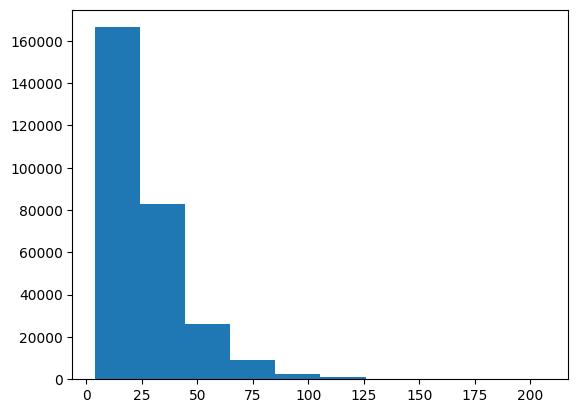

In [51]:
import matplotlib.pyplot as plt

In [53]:
train_df = CandidateMerger(dl, train_candidates, output_dir=candidate_dir, mode="train").load()
test_df = CandidateMerger(dl, test_candidates, output_dir=candidate_dir, mode="test").load()
train_label = dl.load_train_label().with_columns(pl.lit(1).alias("label"))

train_df = train_df.join(train_label, on=["session_id", "yad_no"], how="left").with_columns(
    pl.col("label").fill_null(0)
)

ideal_makp = len(train_df.join(label, on=["session_id", "yad_no"], how="inner")) / train_df["session_id"].n_unique()
wandb.log({"idal_makp": ideal_makp})

# wandb.log({"candidate no hist": plt.hist(train_df.group_by("session_id").count().to_pandas()["count"])})

In [54]:
from atma_16.feature.feature import YadoRawFeature, YadoRankFeature, SessionFeature, MatchModeCDFeature, Feature

with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")

train_feats = [
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.Session),
]

test_feats = [
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.Session),
]

train_feat_depend_feats = [
    MatchModeCDFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.MatchModeCD)
]
test_feat_depend_feats = [
    MatchModeCDFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.MatchModeCD)
]


feats_dic = {
    "train": {
        "df": train_df,
        "feats": train_feats,
    },
    "test": {
        "df": test_df,
        "feats": test_feats,
    },
}
merged_df_dic = {}


def create_feats(df: pl.DataFrame, feats: list[Feature]):
    for feat in feats:
        df = feat.fit(df)
        feat.save(df)


def create_merged_df(df: pl.DataFrame, feats: list[Feature]):
    fm = FeatureMerger(output_dir=feature_dir, features=feats, mode=mode)
    merged_df = fm.merge(df)
    fm.save(merged_df)
    return merged_df


create_feats(train_df, train_feats)
create_feats(train_df, test_feats)
train_merged_df = create_merged_df(train_df, train_feats)
test_merged_df = create_merged_df(test_df, test_feats)

create_feats(train_merged_df, train_feat_depend_feats)
create_feats(test_merged_df, test_feat_depend_feats)

train_df = create_merged_df(train_df, train_feats + train_feat_depend_feats)
test_df = create_merged_df(test_df, test_feats + test_feat_depend_feats)

(13372, 11)
(11223, 11)


 67%|██████▋   | 2/3 [00:00<00:00,  8.48it/s]

YadoRawFeature (7758562, 25)
YadoRankFeature_train (7758562, 31)


100%|██████████| 3/3 [00:00<00:00,  8.24it/s]


SessionFeature_train (7758562, 42)


100%|██████████| 3/3 [00:00<00:00, 14.00it/s]

YadoRawFeature (4265437, 23)
YadoRankFeature_test (4265437, 29)
SessionFeature_test (4265437, 40)



 25%|██▌       | 1/4 [00:00<00:00,  7.54it/s]

YadoRawFeature (7758562, 25)
YadoRankFeature_train (7758562, 31)


 75%|███████▌  | 3/4 [00:00<00:00,  8.71it/s]

SessionFeature_train (7758562, 42)


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

MatchModeCDFeature_train (7758562, 46)



 50%|█████     | 2/4 [00:00<00:00, 14.82it/s]

YadoRawFeature (4265437, 23)
YadoRankFeature_test (4265437, 29)
SessionFeature_test (4265437, 40)


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]

MatchModeCDFeature_test (4272621, 44)


In [55]:
test_pdf = test_df.to_pandas()

X_train = train_df.drop(["fold", "label"]).to_numpy()
y_train = train_df["label"].to_numpy().flatten()
print(X_train.shape, y_train.shape)

(7758562, 44) (7758562,)


In [56]:
from typing import Iterator, Any
import pandas as pd
from sklearn.model_selection import KFold


class ColumnBasedCV:
    def __init__(self, dl: AtmaData16Loader):
        self.label = dl.load_train_label()

    def split(self, X: pl.DataFrame, y: Any, **kwargs: Any) -> Iterator[tuple[np.array, np.array]]:
        for fold in range(5):
            idx_pair = (
                pl.DataFrame(X).join(self.label, on=["session_id"], how="left").with_row_count()[["row_nr", "fold"]]
            )

            train_idx = idx_pair.filter(pl.col("fold") != fold)["row_nr"].to_numpy()
            test_idx = idx_pair.filter(pl.col("fold") == fold)["row_nr"].to_numpy()
            yield train_idx, test_idx


# cv = ColumnBasedCV(dl)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [57]:
# GBDT class
from typing import Any, Callable, Literal, TypeAlias
from catboost import CatBoost, Pool
from lightgbm import LGBMClassifier, LGBMRegressor, LGBMRanker
import lightgbm as lgb

GBDType: TypeAlias = Literal["cat", "xgb", "lgb"]
TaskType: TypeAlias = Literal["bin", "reg", "multi", "rank"]


class GBDT:
    def __init__(
        self,
        gbdt_type: GBDType = "cat",
        task_type: TaskType = "bin",
        model_params: dict[str, Any] | None = None,
        train_params: dict[str, Any] | None = None,
        cv: Callable | None = None,
        callbacks: list[Callable] | None = None,
        **kwargs: Any,
    ):
        self.gbt_type = gbdt_type
        self.task_type = task_type
        self.cv = cv

        if self.cv is None:
            self.cv = KFold(n_splits=5, shuffle=True, random_state=42)

        self.model_params = model_params
        self.train_params = train_params
        self.callbacks = callbacks
        self.kwargs = kwargs


class LGB(GBDT):
    """
    ex. callbacks:
        callbacks=[
            lgb.early_stopping(stopping_rounds=10, verbose=True),
            lgb.log_evaluation(10),
        ],
    ex. train_params: {"num_boost_round": 10000}
    """

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_classes = len(np.unique(y))
        self.models = []
        match self.task_type:
            case "bin" | "multi":
                self.model = LGBMClassifier(**self.model_params)
                oof = np.zeros(shape=(len(y), n_classes), dtype=np.float32)
            case "reg":
                self.model = LGBMRegressor(**self.model_params)
                oof = np.zeros(shape=(len(y)), dtype=np.float32)
            case "rank":
                self.model = LGBMRanker(**self.model_params)
                oof = np.zeros(shape=(len(y)), dtype=np.float32)

        for idx_tr, idx_val in cv.split(X, y):  # type: ignore
            X_tr, y_tr = X[idx_tr], y[idx_tr]
            X_val, y_val = X[idx_val], y[idx_val]

            self.model.fit(
                X_tr,
                y_tr,
                eval_set=[(X_val, y_val)],
                callbacks=self.callbacks,  # type: ignore
            )

            oof[idx_val] = (
                self.model.predict_proba(X_val) if self.task_type in ("bin", "multi") else self.model.predict(X_val)
            )
            self.models.append(self.model)
        return self.models, oof

    def predict(self, X: np.ndarray, model_idx: int):
        return self.models[model_idx].predict_proba(X)

    def feature_importance(self):
        return [model.feature_importances_ for model in self.models]


class CAT(GBDT):
    def fit(self, X: np.ndarray, y: np.ndarray):
        n_classes = len(np.unique(y))
        self.models = []

        match self.task_type:
            case "bin" | "multi":
                self.model = CatBoost(params=self.model_params)
                oof = np.zeros(shape=(len(y), n_classes), dtype=np.float32)

        for idx_tr, idx_val in cv.split(X, y):  # type: ignore
            X_tr, y_tr = X[idx_tr], y[idx_tr]
            X_val, y_val = X[idx_val], y[idx_val]

            clf_train = Pool(X_tr, y_tr)
            clf_val = Pool(X_val, y_val)
            self.model.fit(clf_train, eval_set=[clf_val])

            oof[idx_val] = (
                self.model.predict(X_val, prediction_type="Probability")
                if self.task_type in ("bin", "multi")
                else self.model.predict(X_val)
            )
            self.models.append(self.model)
        return self.models, oof

In [58]:
with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")

In [59]:
# from scorta.model.gradient_boost import GBTWrapper
# gbdt = GBTWrapper("lgb", "bin")
# models, oof = gbdt.fit(X_train.to_pandas(), y_train.to_pandas(), params=lgm_params, cv=cv)


lgb_wrapper = LGB(
    gbdt_type="lgb",
    task_type="bin",
    model_params=cfg.gbdt.lgb.model_params,
    train_params=cfg.gbdt.lgb.train_params,
    cv=cv,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(250),
    ],
)

# cat_wrapper = CAT(
#     gbdt_type="cat",
#     task_type="bin",
#     model_params=dict(cfg.gbdt.cat.model_params),
#     train_params=dict(cfg.gbdt.cat.train_params),
#     cv=cv,
# )
models, oof = lgb_wrapper.fit(X_train, y_train)
# models, oof = cat_wrapper.fit(X_train, y_train)

/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 250 rounds
[50]	valid_0's binary_logloss: 0.0811461
[100]	valid_0's binary_logloss: 0.0806277
[150]	valid_0's binary_logloss: 0.0803556
[200]	valid_0's binary_logloss: 0.080239
[250]	valid_0's binary_logloss: 0.0801196
[300]	valid_0's binary_logloss: 0.0800339
[350]	valid_0's binary_logloss: 0.0799569
[400]	valid_0's binary_logloss: 0.0799022
[450]	valid_0's binary_logloss: 0.0798573
[500]	valid_0's binary_logloss: 0.0798089
[550]	valid_0's binary_logloss: 0.0797721
[600]	valid_0's binary_logloss: 0.0797494
[650]	valid_0's binary_logloss: 0.0797202
[700]	valid_0's binary_logloss: 0.0797015
[750]	valid_0's binary_logloss: 0.0796807
[800]	valid_0's binary_logloss: 0.0796633
[850]	valid_0's binary_logloss: 0.0796574
[900]	valid_0's binary_logloss: 0.0796612
[950]	valid_0's binary_logloss: 0.0796587
[1000]	valid_0's binary_logloss: 0.0796538
[1050]	valid_0's binary_logloss: 0.0796656
[1100]	valid_0's binary_logloss: 0.0796788
[1150]	valid_

/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 250 rounds
[50]	valid_0's binary_logloss: 0.080991
[100]	valid_0's binary_logloss: 0.0804296
[150]	valid_0's binary_logloss: 0.0801555
[200]	valid_0's binary_logloss: 0.0799747
[250]	valid_0's binary_logloss: 0.0798711
[300]	valid_0's binary_logloss: 0.0797694
[350]	valid_0's binary_logloss: 0.0796848
[400]	valid_0's binary_logloss: 0.0796189
[450]	valid_0's binary_logloss: 0.0795826
[500]	valid_0's binary_logloss: 0.079535
[550]	valid_0's binary_logloss: 0.0794933
[600]	valid_0's binary_logloss: 0.0794547
[650]	valid_0's binary_logloss: 0.0794373
[700]	valid_0's binary_logloss: 0.0794179
[750]	valid_0's binary_logloss: 0.0794046
[800]	valid_0's binary_logloss: 0.0793956
[850]	valid_0's binary_logloss: 0.0794107
[900]	valid_0's binary_logloss: 0.079383
[950]	valid_0's binary_logloss: 0.0793727
[1000]	valid_0's binary_logloss: 0.0793673
[1050]	valid_0's binary_logloss: 0.079362
[1100]	valid_0's binary_logloss: 0.0793545
[1150]	valid_0's

/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 250 rounds
[50]	valid_0's binary_logloss: 0.0815112
[100]	valid_0's binary_logloss: 0.0809402
[150]	valid_0's binary_logloss: 0.0806925
[200]	valid_0's binary_logloss: 0.0805439
[250]	valid_0's binary_logloss: 0.0804222
[300]	valid_0's binary_logloss: 0.0803664
[350]	valid_0's binary_logloss: 0.0803083
[400]	valid_0's binary_logloss: 0.080246
[450]	valid_0's binary_logloss: 0.0801971
[500]	valid_0's binary_logloss: 0.0801509
[550]	valid_0's binary_logloss: 0.080121
[600]	valid_0's binary_logloss: 0.0800849
[650]	valid_0's binary_logloss: 0.080057
[700]	valid_0's binary_logloss: 0.0800402
[750]	valid_0's binary_logloss: 0.0800236
[800]	valid_0's binary_logloss: 0.0800127
[850]	valid_0's binary_logloss: 0.080006
[900]	valid_0's binary_logloss: 0.0799896
[950]	valid_0's binary_logloss: 0.0799724
[1000]	valid_0's binary_logloss: 0.079972
[1050]	valid_0's binary_logloss: 0.0799658
[1100]	valid_0's binary_logloss: 0.0799639
[1150]	valid_0's 

/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 250 rounds
[50]	valid_0's binary_logloss: 0.0816005
[100]	valid_0's binary_logloss: 0.081046
[150]	valid_0's binary_logloss: 0.080794
[200]	valid_0's binary_logloss: 0.0806409
[250]	valid_0's binary_logloss: 0.0805156
[300]	valid_0's binary_logloss: 0.0804099
[350]	valid_0's binary_logloss: 0.0803483
[400]	valid_0's binary_logloss: 0.0802843
[450]	valid_0's binary_logloss: 0.0802471
[500]	valid_0's binary_logloss: 0.080215
[550]	valid_0's binary_logloss: 0.0801694
[600]	valid_0's binary_logloss: 0.0801345
[650]	valid_0's binary_logloss: 0.0801254
[700]	valid_0's binary_logloss: 0.0801124
[750]	valid_0's binary_logloss: 0.0800945
[800]	valid_0's binary_logloss: 0.0800787
[850]	valid_0's binary_logloss: 0.0800687
[900]	valid_0's binary_logloss: 0.0800606
[950]	valid_0's binary_logloss: 0.080054
[1000]	valid_0's binary_logloss: 0.0800513
[1050]	valid_0's binary_logloss: 0.0800536
[1100]	valid_0's binary_logloss: 0.0800534
[1150]	valid_0's

/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 250 rounds
[50]	valid_0's binary_logloss: 0.0805366
[100]	valid_0's binary_logloss: 0.0799872
[150]	valid_0's binary_logloss: 0.0797524
[200]	valid_0's binary_logloss: 0.0796009
[250]	valid_0's binary_logloss: 0.0794763
[300]	valid_0's binary_logloss: 0.0793771
[350]	valid_0's binary_logloss: 0.0792755
[400]	valid_0's binary_logloss: 0.0792025
[450]	valid_0's binary_logloss: 0.0792047
[500]	valid_0's binary_logloss: 0.0791683
[550]	valid_0's binary_logloss: 0.0791224
[600]	valid_0's binary_logloss: 0.0790897
[650]	valid_0's binary_logloss: 0.0790647
[700]	valid_0's binary_logloss: 0.0790492
[750]	valid_0's binary_logloss: 0.0790348
[800]	valid_0's binary_logloss: 0.079026
[850]	valid_0's binary_logloss: 0.0790186
[900]	valid_0's binary_logloss: 0.0790156
[950]	valid_0's binary_logloss: 0.0790151
[1000]	valid_0's binary_logloss: 0.0790185
[1050]	valid_0's binary_logloss: 0.0790174
[1100]	valid_0's binary_logloss: 0.0790186
[1150]	valid_

In [62]:
from atma_16.utils.metrics import mapk

oof_df = (
    train_df[["session_id", "yad_no", "label"]]
    .with_columns(pl.Series(oof[:, 1]).alias("score"))
    .sort(["session_id", "score"], descending=(False, True))
    .with_columns(pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank"))
    .filter(pl.col("rank") <= 10)
)

oof_lists = oof_df.group_by("session_id", maintain_order=True).agg(pl.col("yad_no"))["yad_no"].to_list()
y_true = train_label["yad_no"].to_list()
assert len(oof_lists) == len(y_true)
oof_score = mapk(y_true, oof_lists, 10)
print(oof_score)

oof_df.write_parquet(output_dir / f"oof_{oof_score}.parquet")

0.39410034757022944


In [63]:
import numpy as np

# preds = np.array([lgb_wrapper.predict(test_pdf, i) for i in range(5)]).mean(axis=0)
preds = np.array([lgb_wrapper.models[i].predict_proba(test_pdf)[:, 1] for i in range(5)]).mean(axis=0)
sub = test_df.with_columns(pl.Series(preds).alias("score"))[["session_id", "yad_no", "score"]]

/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/src/scorta/scorta/eda/df.py:105: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




(<Figure size 1200x880 with 1 Axes>,
 <Axes: xlabel='feature_importance', ylabel='column'>)

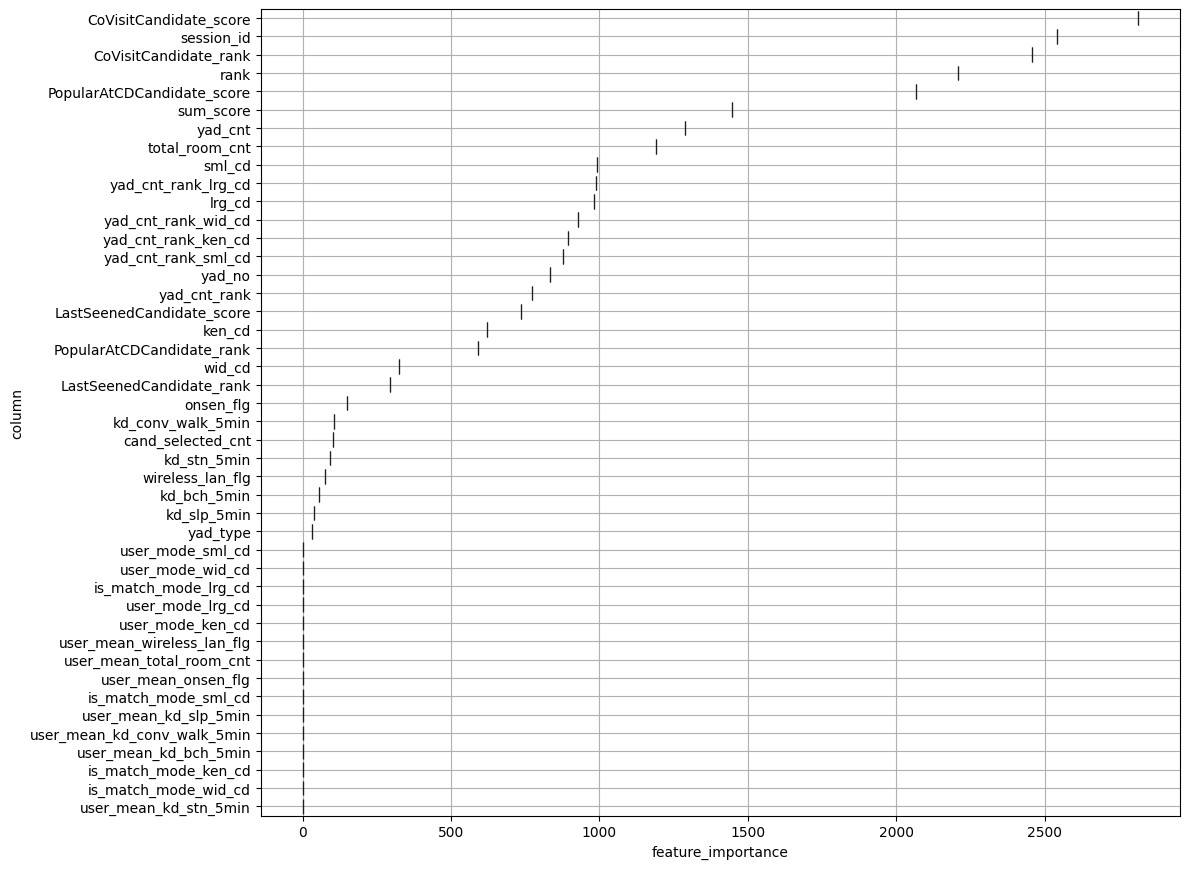

In [67]:
from scorta.eda import df as eda_df

eda_df.visualize_importance(pl.DataFrame(lgb_wrapper.feature_importance()), train_df.drop(["fold", "label"]))

<Axes: ylabel='Count'>

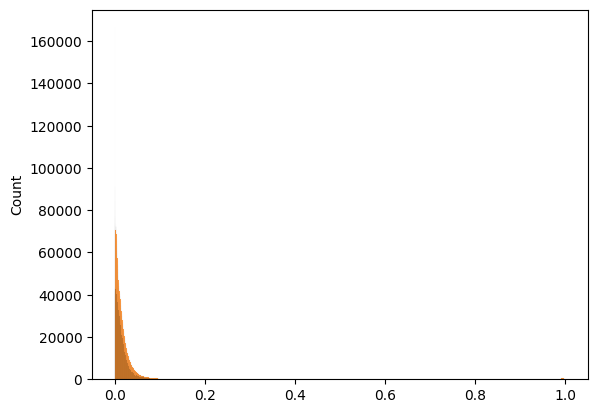

In [65]:
import seaborn as sns

sns.histplot(preds)
sns.histplot(oof[:, 1])

In [66]:
sub_lists = (
    sub.with_columns(
        pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
    )
    .sort(["session_id", "rank"])
    .filter(pl.col("rank") <= 9)
    .group_by("session_id", maintain_order=True)
    .agg("yad_no")["yad_no"]
    .to_list()
)

In [40]:
test_top30_yads = (
    dl.load_test_log().group_by("yad_no").count().sort("count", descending=True).head(30)["yad_no"].to_list()
)

seened_dict: dict[int, np.ndarray] = (
    dl.load_test_log()
    .with_columns([(pl.col("seq_no").max().over("session_id") == pl.col("seq_no")).alias("is_last")])
    .filter(~pl.col("is_last"))
    .group_by("session_id")
    .agg("yad_no")
    .sort("session_id")
    .to_pandas()
    .set_index("session_id")
    .to_dict()["yad_no"]
)


fill_sub_lists = []
for idx, sub_list in enumerate(sub_lists):
    new_sub_list = []
    if sub_list != [None]:
        new_sub_list.extend(sub_list)

    if len(sub_list) < 10:
        if idx in seened_dict:
            new_sub_list.extend(list(seened_dict[idx]))
        new_sub_list.extend(test_top30_yads[:10])

    fill_sub_lists.append(new_sub_list[:10])

In [41]:
np.array(fill_sub_lists).shape

(174700, 10)

In [42]:
sample_sub_df = dl.load_sample_submission("pd")
sample_sub_df.loc[:, :] = np.array(fill_sub_lists)
sample_sub_df.to_csv(f"../output/{exp_name}/sub_df_{oof_score}_add_feat.csv", index=False)